**Credit Card Lead Prediction**


Happy Customer Bank is a mid-sized private bank that deals in all kinds of banking products, like Savings accounts, Current accounts, investment products, credit products, among other offerings.



The bank also cross-sells products to its existing customers and to do so they use different kinds of communication like tele-calling, e-mails, recommendations on net banking, mobile banking, etc. 



In this case, the Happy Customer Bank wants to cross sell its credit cards to its existing customers. The bank has identified a set of customers that are eligible for taking these credit cards.



Now, the bank is looking for your help in identifying customers that could show higher intent towards a recommended credit card, given:

Customer details (gender, age, region etc.)
Details of his/her relationship with the bank (Channel_Code,Vintage, 'Avg_Asset_Value etc.)

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import pickle
from sklearn.preprocessing import OneHotEncoder
from datetime import date, datetime
from sklearn.metrics import roc_auc_score, roc_curve, auc


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
data_train.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [4]:
# Checking number of rows and columns
print("Train - Number of rows: {rows} and columns: {columns}".format(rows=data_train.shape[0], columns=data_train.shape[1]))
print("Test - Number of rows: {rows} and columns: {columns}".format(rows=data_test.shape[0], columns=data_test.shape[1]))

Train - Number of rows: 245725 and columns: 11
Test - Number of rows: 105312 and columns: 10


In [5]:
1045696/43

24318.511627906977

**Check missing values**

In [6]:
missing_percentage = (data_train.isnull().sum()/data_train.shape[0]*100).sort_values(ascending=False)
print(missing_percentage)

Credit_Product         11.934073
ID                      0.000000
Gender                  0.000000
Age                     0.000000
Region_Code             0.000000
Occupation              0.000000
Channel_Code            0.000000
Vintage                 0.000000
Avg_Account_Balance     0.000000
Is_Active               0.000000
Is_Lead                 0.000000
dtype: float64


* __There are approx 12% missing values in credit_product.__

****__Information about the data__****

In [7]:
print(data_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   245725 non-null  object
 1   Gender               245725 non-null  object
 2   Age                  245725 non-null  int64 
 3   Region_Code          245725 non-null  object
 4   Occupation           245725 non-null  object
 5   Channel_Code         245725 non-null  object
 6   Vintage              245725 non-null  int64 
 7   Credit_Product       216400 non-null  object
 8   Avg_Account_Balance  245725 non-null  int64 
 9   Is_Active            245725 non-null  object
 10  Is_Lead              245725 non-null  int64 
dtypes: int64(4), object(7)
memory usage: 20.6+ MB
None


In [8]:
# numerical features
numeric_col = data_train.select_dtypes(include='number')

# categorical features
categorical_col = data_train.select_dtypes(exclude='number')


print("Numerical features in train set: ", len(numeric_col.columns))
print("Categorical features in train set: ", len(categorical_col.columns))

Numerical features in train set:  4
Categorical features in train set:  7


In [9]:
print(data_train.describe())

                 Age        Vintage  Avg_Account_Balance        Is_Lead
count  245725.000000  245725.000000         2.457250e+05  245725.000000
mean       43.856307      46.959141         1.128403e+06       0.237208
std        14.828672      32.353136         8.529364e+05       0.425372
min        23.000000       7.000000         2.079000e+04       0.000000
25%        30.000000      20.000000         6.043100e+05       0.000000
50%        43.000000      32.000000         8.946010e+05       0.000000
75%        54.000000      73.000000         1.366666e+06       0.000000
max        85.000000     135.000000         1.035201e+07       1.000000


* __All the numeric features do not have any negative values__


<AxesSubplot:xlabel='Is_Lead', ylabel='count'>

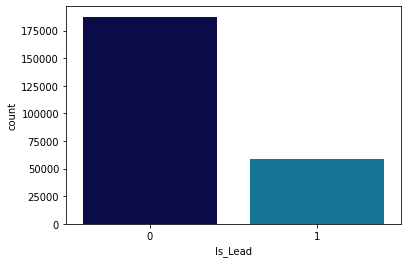

In [10]:
sns.countplot(x='Is_Lead',data=data_train,palette='ocean')

In [11]:
print("Percentage of values with: \n")
print("Class label 0:",round(data_train['Is_Lead'].value_counts()[0]/data_train.shape[0] * 100, 3))
print("Class label 1:",round(data_train['Is_Lead'].value_counts()[1]/data_train.shape[0] * 100, 3))

Percentage of values with: 

Class label 0: 76.279
Class label 1: 23.721


*___As we see, we have imbalanced dataset___*

<AxesSubplot:xlabel='Credit_Product', ylabel='count'>

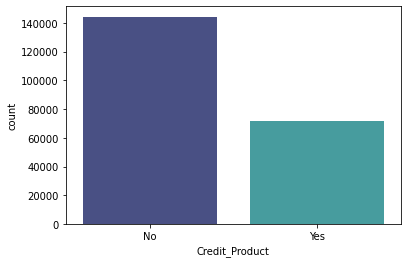

In [12]:
sns.countplot(x='Credit_Product',data=data_train,palette='mako')

In [13]:
print("People having no credit product: ",data_train['Credit_Product'].value_counts()[0])
print("\nPeople having credit product: ",data_train['Credit_Product'].value_counts()[1])
print("\nPeople whose credit product data is missing: " ,data_train['Credit_Product'].isnull().sum())

People having no credit product:  144357

People having credit product:  72043

People whose credit product data is missing:  29325


*___Most number of people do not have any credict product___*

### Data Cleaning

In [14]:
cp_grp = data_train.groupby(['Region_Code'])['Credit_Product'].value_counts()

In [15]:
print(cp_grp)

Region_Code  Credit_Product
RG250        No                 1521
             Yes                 802
RG251        No                 3574
             Yes                1661
RG252        No                 3279
                               ...  
RG282        Yes                1362
RG283        No                14450
             Yes               10213
RG284        No                 9718
             Yes                6636
Name: Credit_Product, Length: 70, dtype: int64


#### Getting more insights about missing credit product data

In [16]:
credit_pro_int = data_train.loc[(data_train['Is_Lead'] == 1) & (data_train['Credit_Product'].isnull())]
print(len(credit_pro_int))

24975


* ___Number of people who are intrested in credit card and have missing credit product data: 24975___

In [17]:
credit_pr_no_int = data_train.loc[(data_train['Is_Lead'] == 0) & (data_train['Credit_Product'].isnull())]
print(len(credit_pr_no_int))

4350


* ___Number of people who are not intrested in credit card and have missing credit product data: 4350___

In [18]:
# func = lambda x: round(100*x.count()/data_train.shape[0],4)
pt = pd.pivot_table(data_train,index=["Occupation","Credit_Product"],values=["Age"],aggfunc=[len])
print(pt)

                                len
                                Age
Occupation    Credit_Product       
Entrepreneur  No                  2
              Yes              1649
Other         No              39425
              Yes             21421
Salaried      No              52423
              Yes             15360
Self_Employed No              52507
              Yes             33613


* ___We can observe that self employed people buy most credit products___
* ___Majority of Entreprenuers buy credit product as it is necessary for their business___

<AxesSubplot:>

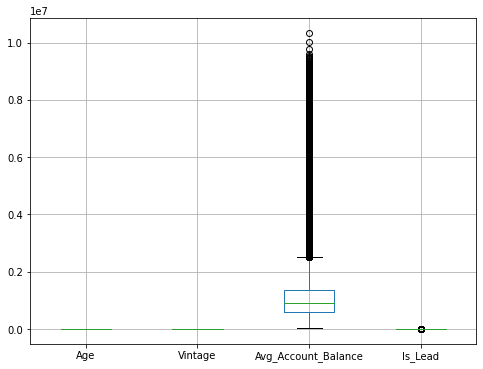

In [19]:
plt.figure(figsize=(8,6))
data_train.boxplot()

<AxesSubplot:ylabel='Vintage'>

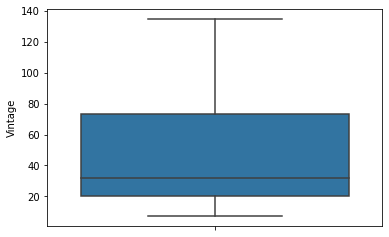

In [20]:
sns.boxplot(y='Vintage',data=data_train)

<AxesSubplot:ylabel='Avg_Account_Balance'>

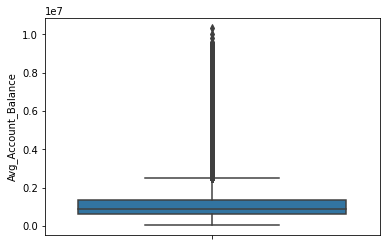

In [21]:
# plt.figure(figsize=(8,5))
sns.boxplot(y='Avg_Account_Balance',data=data_train)

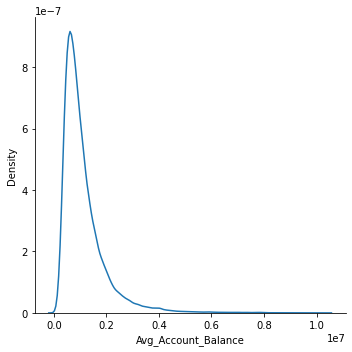

In [22]:
sns.displot(data_train['Avg_Account_Balance'], kind='kde')

* ___Average account balance is right skewed___
* ___As the people earning lot of money would reduce___

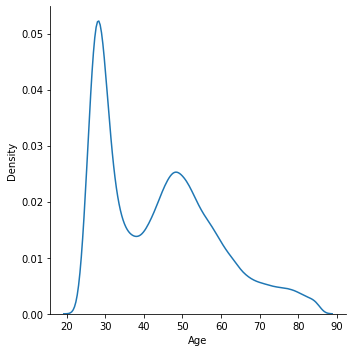

In [23]:
sns.displot(data_train['Age'], kind='kde')

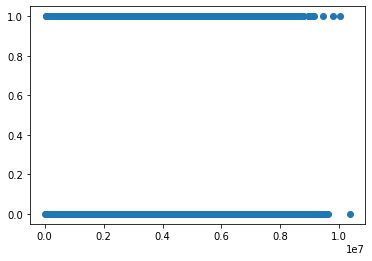

In [24]:
plt.scatter(data_train['Avg_Account_Balance'], data_train['Is_Lead'])
plt.show()

In [25]:
# 5th and 95th percentile value
lower_boundary = data_train['Avg_Account_Balance'].quantile(0.01)
upper_boundary = data_train['Avg_Account_Balance'].quantile(0.99)
print("1st percentile: ",lower_boundary)
print("99th percentile: ",upper_boundary)

1st percentile:  233678.0
99th percentile:  4472872.600000013


* ___Above values look normal as people can have such balances___

In [26]:
data_train['Avg_Account_Balance'] = np.log(data_train['Avg_Account_Balance'])

data_test['Avg_Account_Balance'] = np.log(data_test['Avg_Account_Balance'])

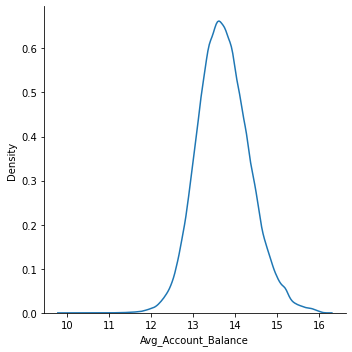

In [27]:
sns.displot(data_train['Avg_Account_Balance'], kind='kde')

* ___Now we have transformed to gaussian distribution___

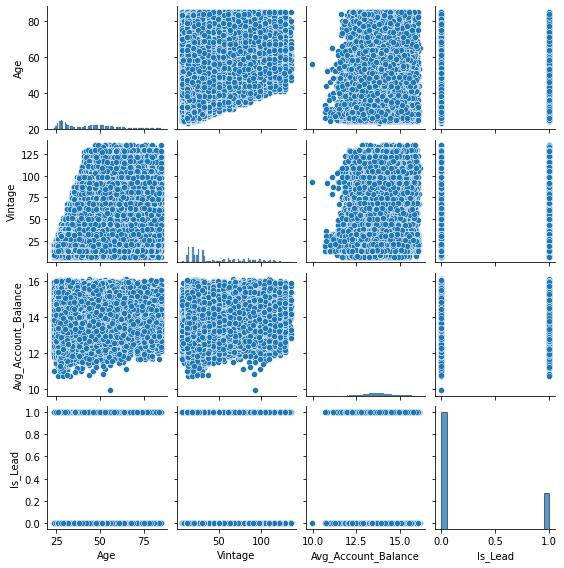

In [28]:
sns.pairplot(data_train, height=2)
plt.show()

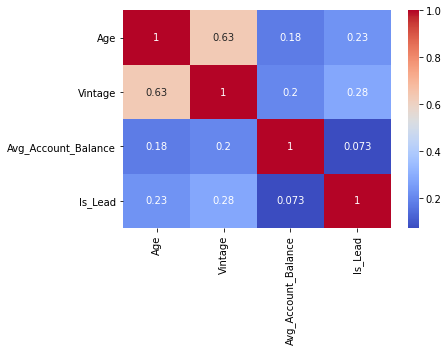

In [29]:
# matrix = np.triu(data_train.corr())
sns.heatmap(data_train.corr(), annot=True, cmap= 'coolwarm')
plt.show()

* ___There is strong correlation between age and vintage features___

**Identifying top 6 categories of Regin_Code**

Text(0, 0.5, 'Number of customers')

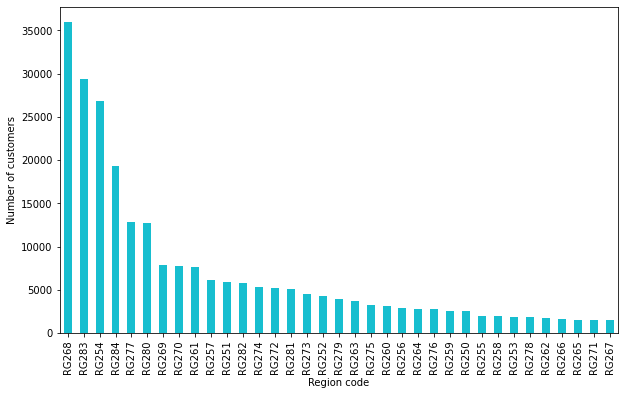

In [30]:
plt.figure(figsize=(10,6))
data_train['Region_Code'].value_counts().plot(kind='bar', color='#17becf')
plt.xlabel('Region code')
plt.ylabel('Number of customers')

In [31]:
# identifying top 6 categories of Regin_Code
top_6_occurring_cat = [cat for cat in data_train.Region_Code.value_counts().sort_values(ascending = False).head(6).index]
print(top_6_occurring_cat)

['RG268', 'RG283', 'RG254', 'RG284', 'RG277', 'RG280']


In [32]:
# converting top 6 categories to numeric 
for cat in top_6_occurring_cat:
    # whenever data['b'] == cat replace it with 1 else 0
    data_train[cat] = np.where(data_train['Region_Code'] == cat, 1, 0) 

In [33]:
for cat in top_6_occurring_cat:
    data_test[cat] = np.where(data_test['Region_Code'] == cat, 1, 0) 

In [34]:
# # Imputing with new value
data_train['Credit_Product']= data_train['Credit_Product'].fillna('not_disclosed')
data_test['Credit_Product']= data_test['Credit_Product'].fillna('not_disclosed')

Text(0, 0.5, 'Number of customers')

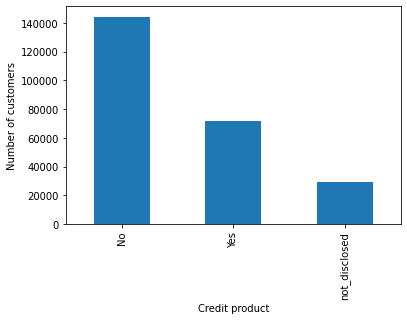

In [35]:
data_train['Credit_Product'].value_counts().plot.bar()
plt.xlabel('Credit product')
plt.ylabel('Number of customers')

In [36]:
data_train['Credit_Product'].isnull().sum(),data_test['Credit_Product'].isnull().sum()

(0, 0)

In [37]:
# standardizing numerical features such that they have mean = 0, sd = 1
def standardize(train_data, test_data, standardize_columns):
    scaler = StandardScaler()
    train_data = train_data[standardize_columns]
    test_data = test_data[standardize_columns]

    scaled_data = scaler.fit(train_data)
    std_train_data = scaled_data.transform(train_data)
    std_test_data = scaled_data.transform(test_data)
    
    path = 'standard_scaler.pkl'
    with open(path, 'wb') as f:
        pickle.dump(scaled_data, f)

    return std_train_data, std_test_data

In [38]:
# One hot encoding which gives bag of words representation for categorical features
def one_hot_encoder(train_data, test_data, vectorize_columns):
    train_data = train_data[vectorize_columns]
    test_data = test_data[vectorize_columns]

    le = OneHotEncoder()
    encode_data = le.fit(train_data)

    vect_train_data = encode_data.transform(train_data)
    vect_test_data = encode_data.transform(test_data)
    
    path = 'label_encode.pkl'
    with open(path, 'wb') as f:
        pickle.dump(encode_data, f)

    return vect_train_data, vect_test_data

In [39]:
# Seperate Features and Target
X= data_train.drop(columns = ['Is_Lead','ID','Region_Code'], axis=1)
y= data_train['Is_Lead']

In [40]:
# splitting data into train and test dataset (80:20)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [41]:
# vectorizing categorical features
vectorize_columns = X_train.select_dtypes(include='object').columns.tolist()
vectorize_train, vectorize_test = one_hot_encoder(X_train, X_test, vectorize_columns)

In [42]:
# feature scaling 
standardize_columns = ['Age', 'Avg_Account_Balance', 'Vintage']
standardize_train, standardize_test = standardize(X_train, X_test, standardize_columns)

In [43]:
multi_cat = ['RG268', 'RG283', 'RG254', 'RG284', 'RG277', 'RG280']

In [44]:
# stacking the features
X_tr = hstack((vectorize_train, standardize_train, X_train[multi_cat])).tocsr()
X_te = hstack((vectorize_test, standardize_test, X_test[multi_cat])).tocsr()

In [45]:
print("Shape of X_tr: ",X_tr.shape)
print("Shape of X_te: ",X_te.shape)

Shape of X_tr:  (196580, 24)
Shape of X_te:  (49145, 24)


In [46]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 600, num = 5)]
# Number of features to consider at every split
# max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(6, 16,4)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [100, 225, 350, 475, 600], 'max_depth': [6, 9, 12, 16], 'min_samples_leaf': [4, 6, 8]}


In [79]:
from sklearn.ensemble import RandomForestClassifier

start = datetime.now()

# tun`ed_parameters = {'n_estimators' : [20,80,100,150], 'max_depth' : [3,5,8,10,12]}


clf = RandomForestClassifier(max_depth=12, n_estimators=150, class_weight='balanced')
# clf = GridSearchCV(model,tuned_parameters, cv=5,return_train_score=True, scoring='roc_auc', verbose=12)
clf.fit(X_tr, y_train)

print('Time taken :', datetime.now() - start)

Time taken : 0:01:52.716788


In [59]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedKFold
  
# # Creating the hyperparameter grid
# param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2', 'l1']}
  
# print(param_grid)
# # Instantiating logistic regression classifier
# model = LogisticRegression(class_weight='balanced', random_state=42)
  
# # Instantiating the GridSearchCV object
# clf = GridSearchCV(model, param_grid, cv=StratifiedKFold(5),return_train_score=True, scoring='roc_auc',verbose=12)
  
# clf.fit(X_tr, y_train)

{'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l2', 'l1']}
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START C=0.0001, penalty=l2.......................................
[CV 1/5; 1/16] END C=0.0001, penalty=l2;, score=(train=0.846, test=0.847) total time=   0.2s
[CV 2/5; 1/16] START C=0.0001, penalty=l2.......................................
[CV 2/5; 1/16] END C=0.0001, penalty=l2;, score=(train=0.846, test=0.847) total time=   0.2s
[CV 3/5; 1/16] START C=0.0001, penalty=l2.......................................
[CV 3/5; 1/16] END C=0.0001, penalty=l2;, score=(train=0.847, test=0.844) total time=   0.2s
[CV 4/5; 1/16] START C=0.0001, penalty=l2.......................................
[CV 4/5; 1/16] END C=0.0001, penalty=l2;, score=(train=0.847, test=0.844) total time=   0.2s
[CV 5/5; 1/16] START C=0.0001, penalty=l2.......................................
[CV 5/5; 1/16] END C=0.0001, penalty=l2;, score=(train=0.846, test=0.850) total time=

[CV 1/5; 11/16] END C=10, penalty=l2;, score=(train=0.859, test=0.859) total time=   0.4s
[CV 2/5; 11/16] START C=10, penalty=l2..........................................
[CV 2/5; 11/16] END C=10, penalty=l2;, score=(train=0.859, test=0.859) total time=   0.4s
[CV 3/5; 11/16] START C=10, penalty=l2..........................................
[CV 3/5; 11/16] END C=10, penalty=l2;, score=(train=0.859, test=0.857) total time=   0.4s
[CV 4/5; 11/16] START C=10, penalty=l2..........................................
[CV 4/5; 11/16] END C=10, penalty=l2;, score=(train=0.860, test=0.856) total time=   0.4s
[CV 5/5; 11/16] START C=10, penalty=l2..........................................
[CV 5/5; 11/16] END C=10, penalty=l2;, score=(train=0.858, test=0.863) total time=   0.5s
[CV 1/5; 12/16] START C=10, penalty=l1..........................................
[CV 1/5; 12/16] END C=10, penalty=l1;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5; 12/16] START C=10, penalty=l1.....................

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=42),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l2', 'l1']},
             return_train_score=True, scoring='roc_auc', verbose=12)

In [78]:
# # # Print the tuned parameters and score
# print("Tuned Parameters: {}".format(clf.best_params_)) 
# print("Best score is {}".format(clf.best_score_))

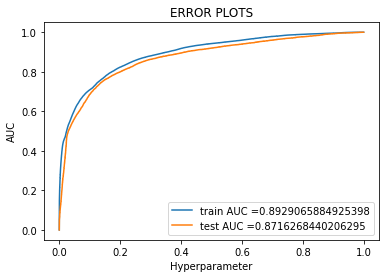

In [80]:
# ROC-AUC plot
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, clf.predict_proba(X_tr)[:,1])
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, clf.predict_proba(X_te)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [89]:
y_pred_acc = clf.predict(X_te)
print('ROC score : ' + str(roc_auc_score(y_test,y_pred_acc)))

ROC score : 0.8042052599621852


In [62]:
pickle.dump(clf, open('model.pkl','wb'))

In [82]:
standardize_num_data = data_test[standardize_columns]
sc = pickle.load(open('standard_scaler.pkl','rb'))
test_standardize_data = sc.transform(standardize_num_data)

In [83]:
vectorize_cat_data = data_test[vectorize_columns]

le = pickle.load(open('label_encode.pkl','rb'))
test_vectorize_data = le.transform(vectorize_cat_data)

In [84]:
pro_test_data = hstack((test_vectorize_data, standardize_num_data, data_test[multi_cat])).tocsr()

In [85]:
predicted_val = pickle.load(open('model.pkl','rb'))

y_pred = predicted_val.predict(pro_test_data)

In [86]:
submission = data_test.loc[:,['ID']]

In [87]:
submission['Is_Lead'] = y_pred
submission.to_csv('credit.csv', index=False)
print(submission.head())

         ID  Is_Lead
0  VBENBARO        1
1  CCMEWNKY        1
2  VK3KGA9M        1
3  TT8RPZVC        1
4  SHQZEYTZ        1
